In [1]:
! pip install torch-geometric

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import time
from datetime import datetime
import queue
import threading
import torch.nn as nn
# Preprocessing & ML
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report
)
import random

# Torch & PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.loader import DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Formatting
from tabulate import tabulate

# Pandas display option
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (15, 6)


In [3]:
df=pd.read_csv("/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv")

In [4]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [5]:
df.shape

(24386900, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [7]:
df.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

In [8]:
# Fill string (object) columns with mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Fill numeric columns with mean
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

/tmp/ipykernel_300/1990305226.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipykernel_300/1990305226.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [9]:
df.isnull().sum()

User              0
Card              0
Year              0
Month             0
Day               0
Time              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Errors?           0
Is Fraud?         0
dtype: int64

In [10]:
df["Is Fraud?"].value_counts()

Is Fraud?
No     24357143
Yes       29757
Name: count, dtype: int64

In [11]:
top_20_cities=df["Merchant City"].value_counts().nlargest(20).index
df["Merchant City"]=df["Merchant City"].apply(lambda x: x if x in top_20_cities else "other")

In [12]:
fraud_df = df[df["Is Fraud?"] == "Yes"].sample(n=5000, random_state=42)
nonfraud_df = df[df["Is Fraud?"] == "No"].sample(n=5000, random_state=42)

# Combine and shuffle the new balanced DataFrame
df = pd.concat([fraud_df, nonfraud_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,332,1,2008,5,8,16:48,$11.36,Online Transaction,-2042049018365856408,ONLINE,CA,50956.442115,5815,Insufficient Balance,No
1,55,3,2006,7,12,14:05,$220.10,Swipe Transaction,-7231389139399574921,other,Algeria,50956.442115,5310,Insufficient Balance,Yes
2,445,0,2005,11,28,13:34,$0.21,Swipe Transaction,2422025050781062194,other,AR,72099.000000,5912,Insufficient Balance,Yes
3,1607,2,2013,7,27,08:23,$902.78,Swipe Transaction,-8393403536864044661,other,OH,44680.000000,8011,Insufficient Balance,Yes
4,849,3,2012,1,26,12:01,$492.00,Online Transaction,1715299929786123066,ONLINE,CA,50956.442115,3722,Insufficient Balance,Yes


In [14]:
# Convert Amount to numeric
df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

In [15]:
# Combine date and time into datetime
df['DateTime'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' + df['Time'],
    format='%Y-%m-%d %H:%M')

In [16]:
# Extract hour for temporal analysis
df['Hour'] = df['DateTime'].dt.hour

In [17]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,DateTime,Hour
0,332,1,2008,5,8,16:48,11.36,Online Transaction,-2042049018365856408,ONLINE,CA,50956.442115,5815,Insufficient Balance,No,2008-05-08 16:48:00,16
1,55,3,2006,7,12,14:05,220.10,Swipe Transaction,-7231389139399574921,other,Algeria,50956.442115,5310,Insufficient Balance,Yes,2006-07-12 14:05:00,14
2,445,0,2005,11,28,13:34,0.21,Swipe Transaction,2422025050781062194,other,AR,72099.000000,5912,Insufficient Balance,Yes,2005-11-28 13:34:00,13
3,1607,2,2013,7,27,08:23,902.78,Swipe Transaction,-8393403536864044661,other,OH,44680.000000,8011,Insufficient Balance,Yes,2013-07-27 08:23:00,8
4,849,3,2012,1,26,12:01,492.00,Online Transaction,1715299929786123066,ONLINE,CA,50956.442115,3722,Insufficient Balance,Yes,2012-01-26 12:01:00,12


In [18]:
df['Date'] = df['DateTime'].dt.date
df['User_Date'] = df['User'].astype(str) + '_' + df['Date'].astype(str)
df['Merchant_Date'] = df['Merchant Name'].astype(str) + '_' + df['Date'].astype(str)
df['User_Freq_Day'] = df.groupby('User_Date')['User'].transform('count')
df['Merchant_Freq_Day'] = df.groupby('Merchant_Date')['Merchant Name'].transform('count')

In [19]:
df = df.sort_values(['User', 'DateTime'])
df['Time_Diff_Hours'] = df.groupby('User')['DateTime'].diff().dt.total_seconds() / 3600
df['Time_Diff_Hours'] = df['Time_Diff_Hours'].fillna(0)  # First transaction gets 0

In [20]:
df['Log_Amount'] = np.log1p(df['Amount'])  # Log-transform to handle skewness
df['User_Avg_Amount'] = df.groupby('User')['Amount'].transform('mean')
df['Amount_Deviation'] = df['Amount'] - df['User_Avg_Amount']

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
df['Prev_City'] = df.groupby('User')['Merchant City'].shift(1)
df['City_Change'] = (df['Merchant City'] != df['Prev_City']) & (df['Time_Diff_Hours'] < 24)
df['City_Change'] = df['City_Change'].astype(int)
df['Prev_City'] = df['Prev_City'].fillna(df['Merchant City'])

In [22]:
df['Day_of_Week'] = df['DateTime'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
df['Time_of_Day'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], include_lowest=True)

In [23]:
G = nx.from_pandas_edgelist(df, source='User', target='Merchant Name')
user_degrees = dict(G.degree(df['User'].unique()))
merchant_degrees = dict(G.degree(df['Merchant Name'].unique()))
df['User_Degree'] = df['User'].map(user_degrees).fillna(0)
df['Merchant_Degree'] = df['Merchant Name'].map(merchant_degrees).fillna(0)

In [24]:
def categorize_merchant_degree(degree):
    if degree == 1:
        return "Unique"
    elif degree <= 10:
        return "Low"
    elif degree <= 100:
        return "Medium"
    elif degree <= 1000:
        return "High"
    else:
        return "Extreme"

df['Merchant_Degree'] = df['Merchant_Degree'].apply(categorize_merchant_degree)

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Use Chip'] = le.fit_transform(df['Use Chip'])
le_city = LabelEncoder()
df['Merchant City'] = le_city.fit_transform(df['Merchant City'])
df['Is Fraud?'] = df['Is Fraud?'].map({'No': 0, 'Yes': 1})

In [26]:
label_name=["No","Yes"]

In [27]:
city_mapping = dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))

for city, code in city_mapping.items():
    print(f"{city} => {code}")

Atlanta => 0
Bronx => 1
Brooklyn => 2
Chicago => 3
Dallas => 4
Houston => 5
Indianapolis => 6
Las Vegas => 7
Los Angeles => 8
Louisville => 9
Miami => 10
Minneapolis => 11
New York => 12
ONLINE => 13
Orlando => 14
Philadelphia => 15
San Antonio => 16
San Diego => 17
San Francisco => 18
Tucson => 19
other => 20


In [28]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,DateTime,Hour,Date,User_Date,Merchant_Date,User_Freq_Day,Merchant_Freq_Day,Time_Diff_Hours,Log_Amount,User_Avg_Amount,Amount_Deviation,Prev_City,City_Change,Day_of_Week,Is_Weekend,Time_of_Day,User_Degree,Merchant_Degree
752,0,0,2004,5,24,11:27,2.30,2,-34551508091458520,20,CA,91750.0,5912,Insufficient Balance,0,2004-05-24 11:27:00,11,2004-05-24,0_2004-05-24,-34551508091458520_2004-05-24,1,1,0.000000,1.193922,92.105714,-89.805714,other,1,0,0,Morning,6,Unique
4753,0,3,2006,4,16,05:24,128.35,2,5817218446178736267,20,CA,91750.0,5912,Insufficient Balance,0,2006-04-16 05:24:00,5,2006-04-16,0_2006-04-16,5817218446178736267_2006-04-16,1,1,16601.950000,4.862522,92.105714,36.244286,other,0,6,1,Night,6,Medium
3059,0,3,2008,1,25,06:18,149.12,2,4060646732831064559,20,CA,91750.0,5411,Insufficient Balance,0,2008-01-25 06:18:00,6,2008-01-25,0_2008-01-25,4060646732831064559_2008-01-25,1,1,15576.900000,5.011435,92.105714,57.014286,other,0,4,0,Night,6,Unique
1558,0,3,2008,10,12,15:54,96.19,2,3189517333335617109,20,CA,91750.0,5311,Insufficient Balance,1,2008-10-12 15:54:00,15,2008-10-12,0_2008-10-12,3189517333335617109_2008-10-12,1,1,6273.600000,4.576668,92.105714,4.084286,other,0,6,1,Afternoon,6,Medium
2062,0,0,2013,9,14,09:55,71.56,2,3952145593743244256,20,CA,91750.0,7538,Insufficient Balance,0,2013-09-14 09:55:00,9,2013-09-14,0_2013-09-14,3952145593743244256_2013-09-14,1,1,43146.016667,4.284414,92.105714,-20.545714,other,0,5,1,Morning,6,Low


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


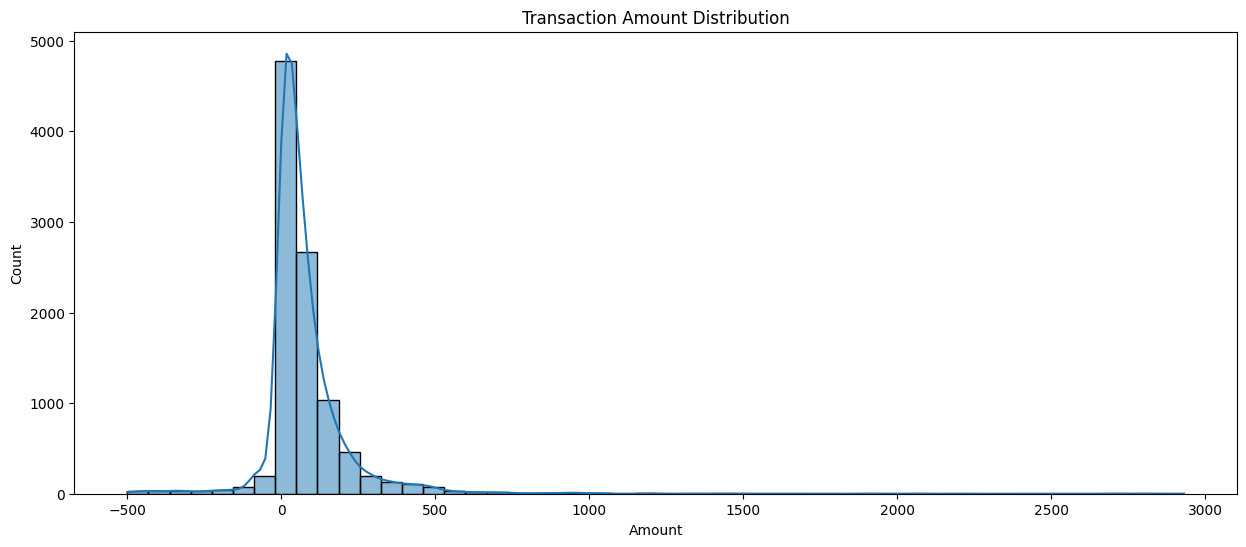

In [29]:
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


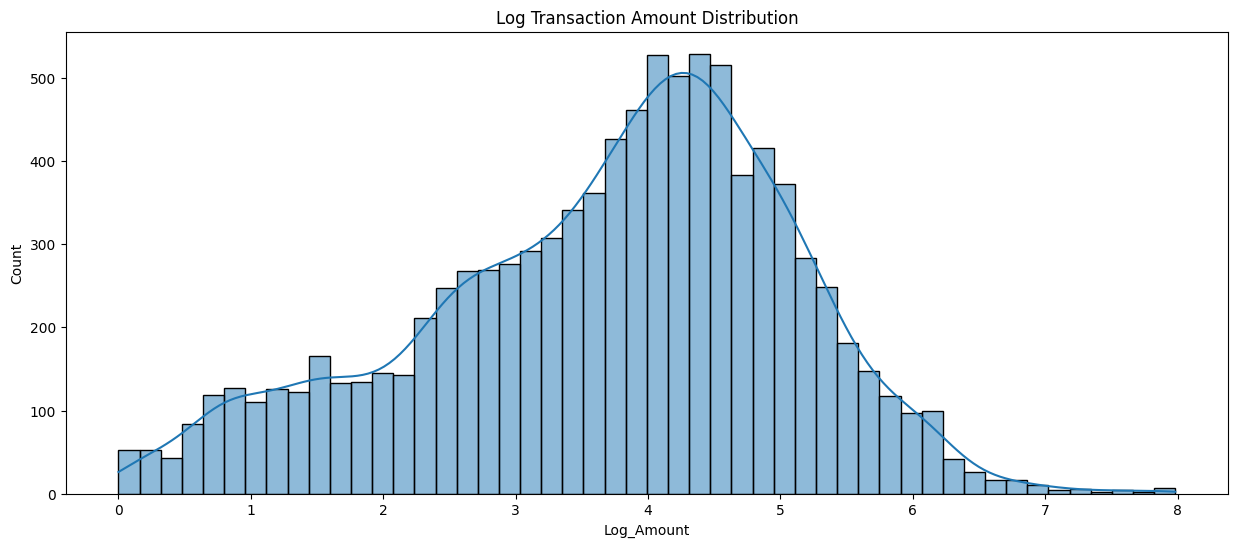

In [30]:
sns.histplot(df['Log_Amount'], bins=50, kde=True)
plt.title("Log Transaction Amount Distribution")
plt.show()


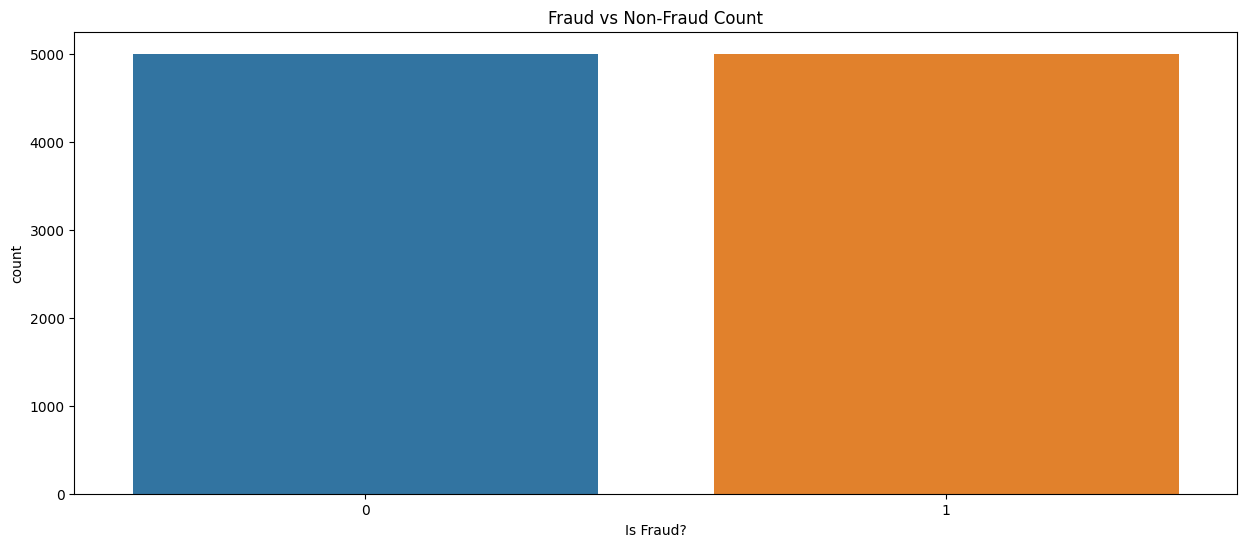

In [31]:
sns.countplot(x='Is Fraud?', data=df)
plt.title("Fraud vs Non-Fraud Count")
plt.show()

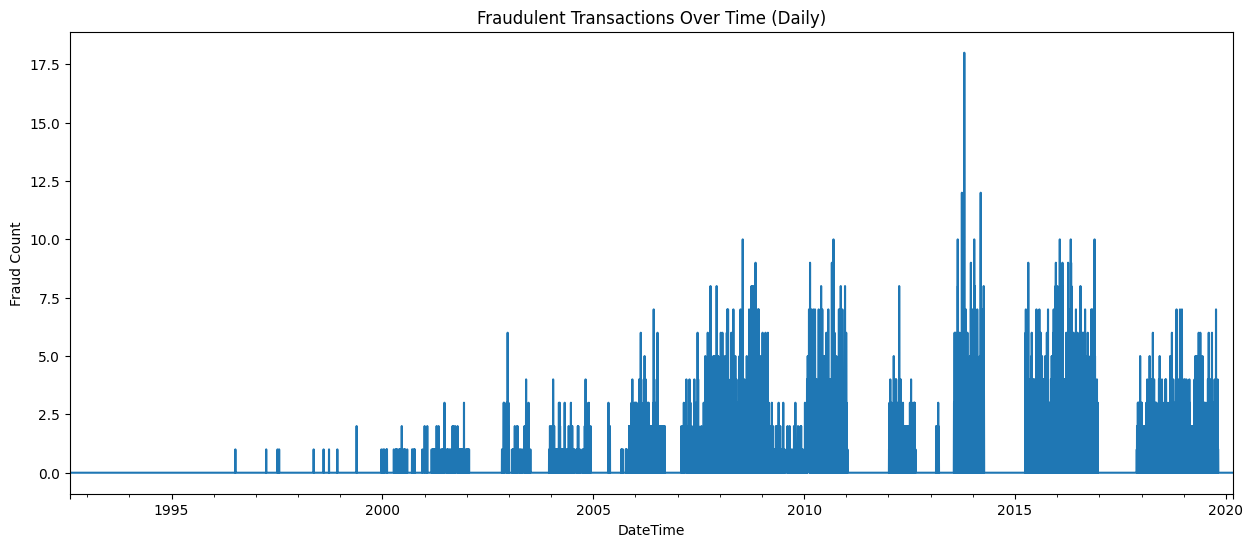

In [32]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime')['Is Fraud?'].resample('D').sum().plot()
plt.title("Fraudulent Transactions Over Time (Daily)")
plt.ylabel("Fraud Count")
plt.show()

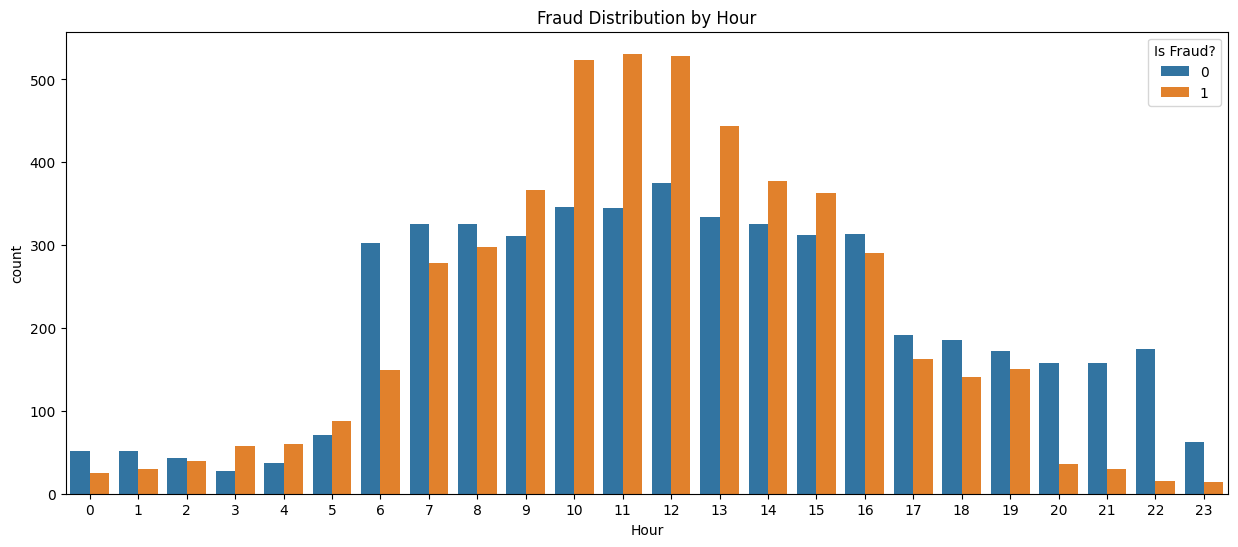

In [33]:
sns.countplot(x='Hour', hue='Is Fraud?', data=df)
plt.title("Fraud Distribution by Hour")
plt.show()

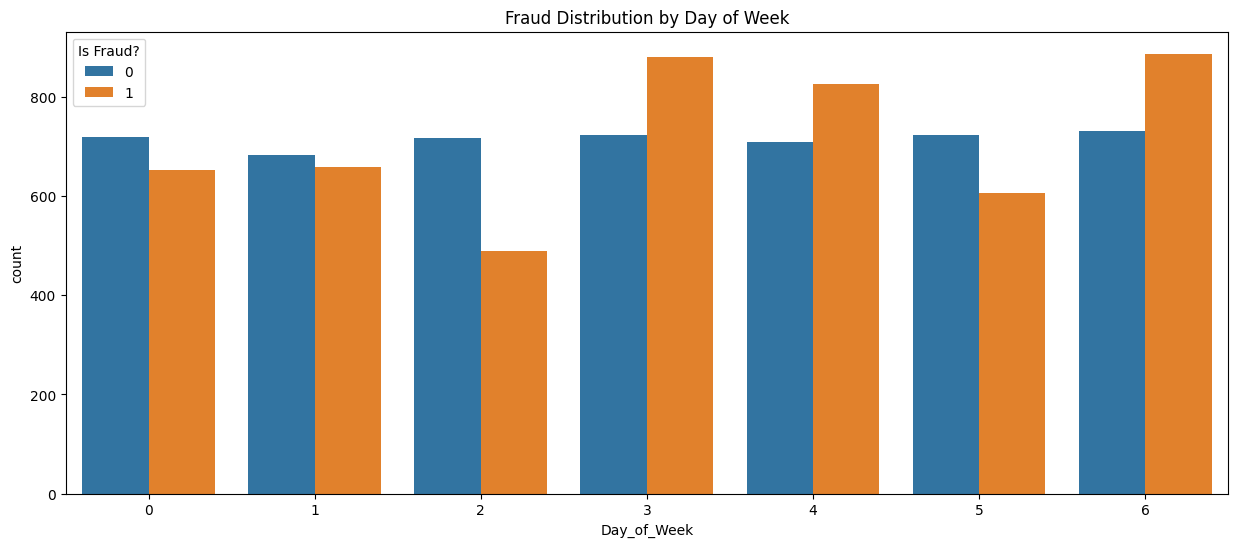

In [34]:
sns.countplot(x='Day_of_Week', hue='Is Fraud?', data=df)
plt.title("Fraud Distribution by Day of Week")
plt.show()

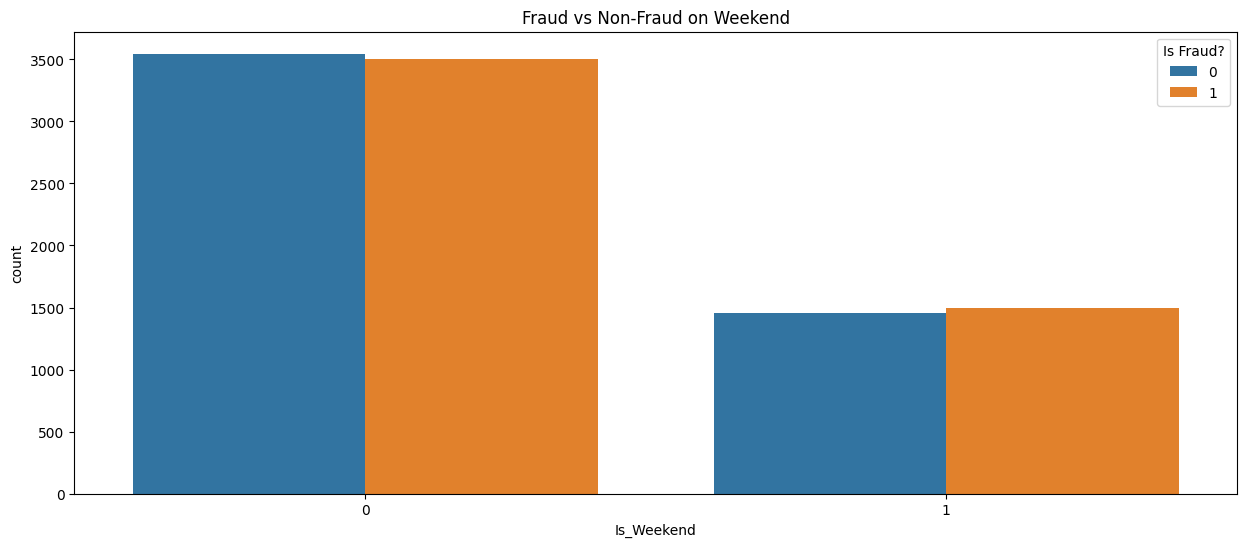

In [35]:
sns.countplot(x='Is_Weekend', hue='Is Fraud?', data=df)
plt.title("Fraud vs Non-Fraud on Weekend")
plt.show()

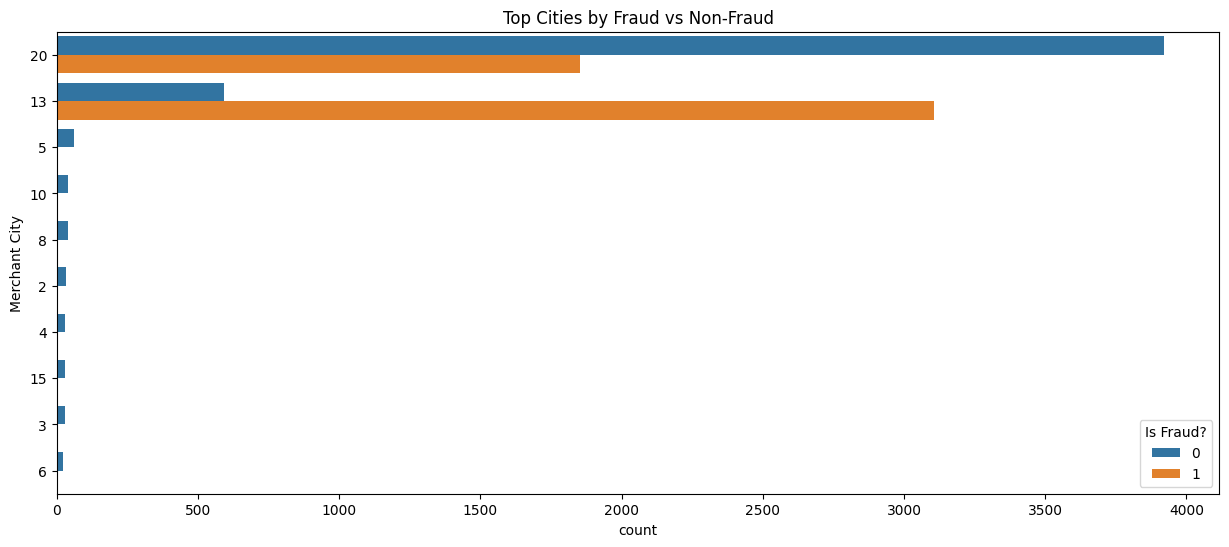

In [36]:
top_cities = df['Merchant City'].value_counts().nlargest(10).index
sns.countplot(y='Merchant City', data=df[df['Merchant City'].isin(top_cities)],
              order=top_cities, hue='Is Fraud?')
plt.title("Top Cities by Fraud vs Non-Fraud")
plt.show()

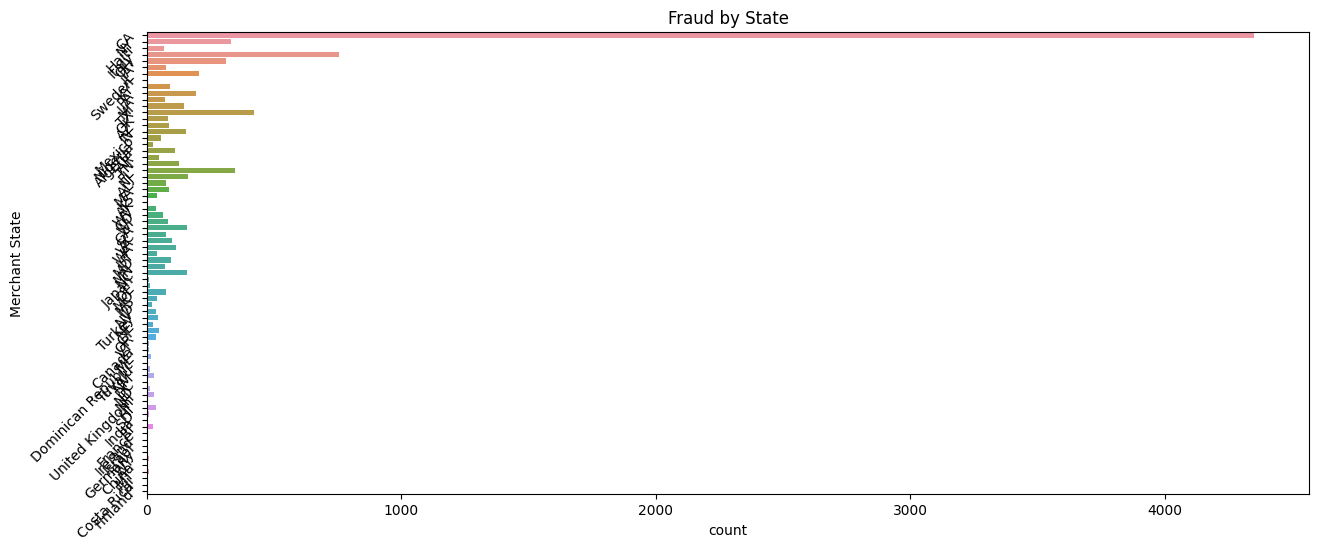

In [37]:
sns.countplot(y='Merchant State', data=df[: 50000])
plt.title("Fraud by State")
plt.yticks(rotation=45)
plt.show()

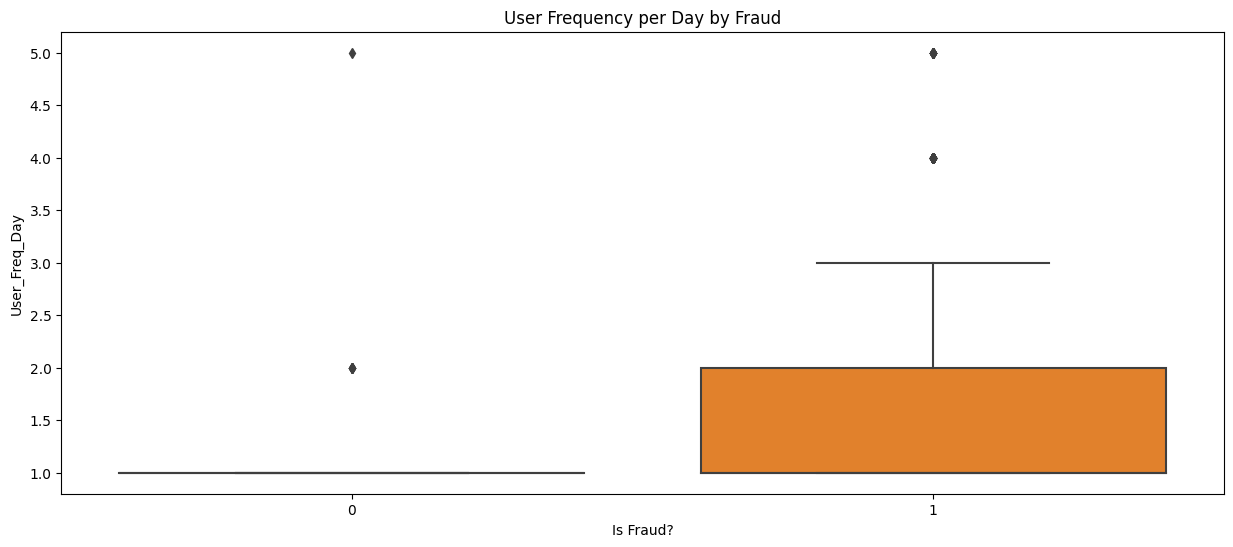

In [38]:
sns.boxplot(x='Is Fraud?', y='User_Freq_Day', data=df)
plt.title("User Frequency per Day by Fraud")
plt.show()

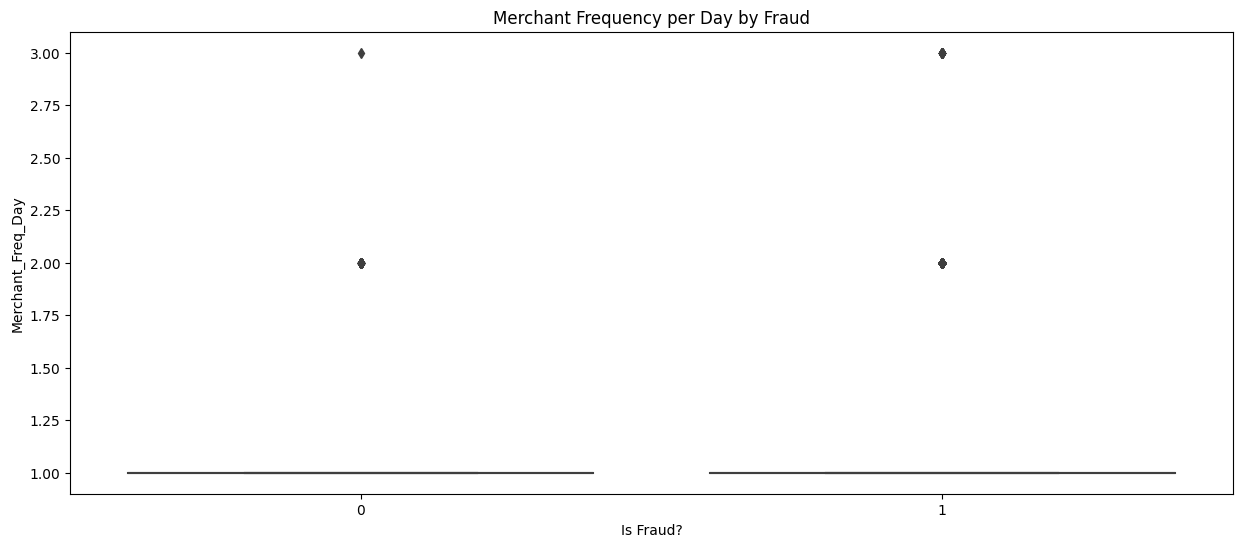

In [39]:
sns.boxplot(x='Is Fraud?', y='Merchant_Freq_Day', data=df)
plt.title("Merchant Frequency per Day by Fraud")
plt.show()

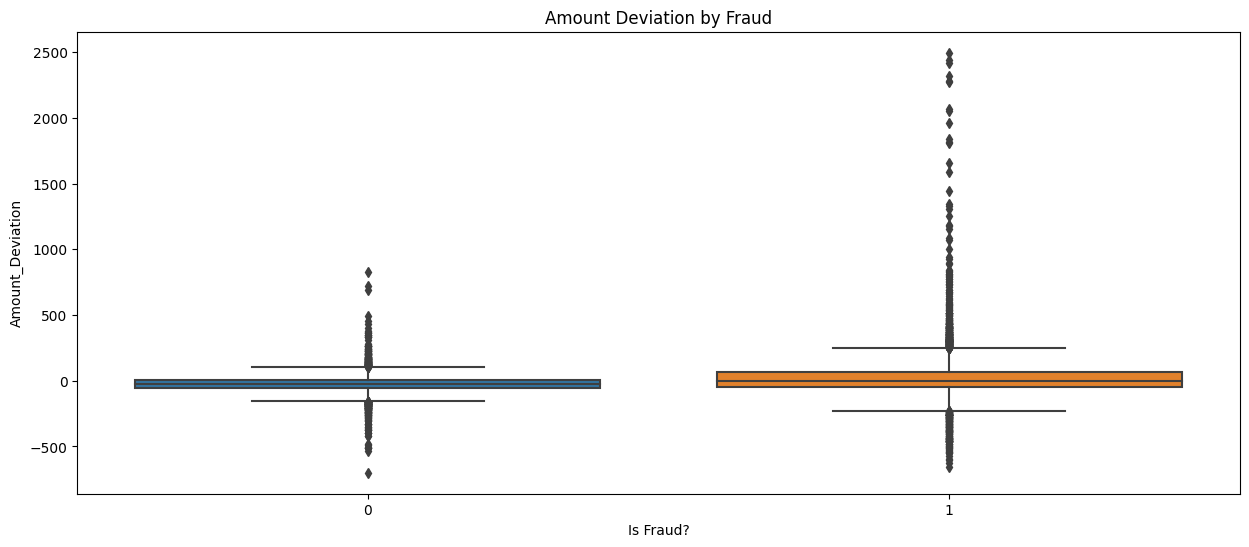

In [40]:
sns.boxplot(x='Is Fraud?', y='Amount_Deviation', data=df)
plt.title("Amount Deviation by Fraud")
plt.show()

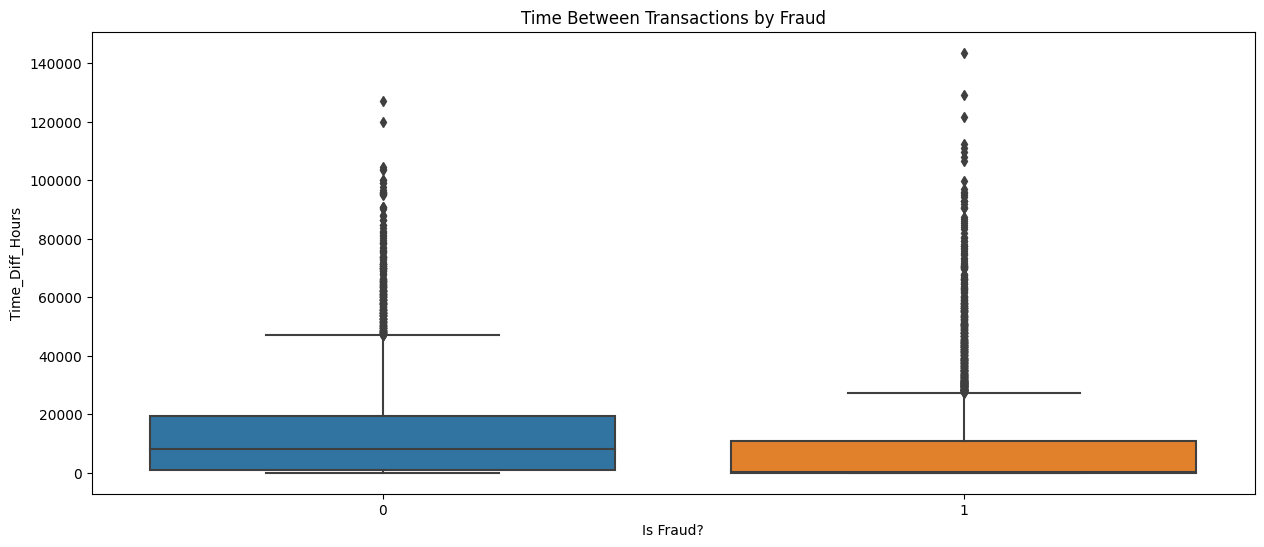

In [41]:
sns.boxplot(x='Is Fraud?', y='Time_Diff_Hours', data=df)
plt.title("Time Between Transactions by Fraud")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


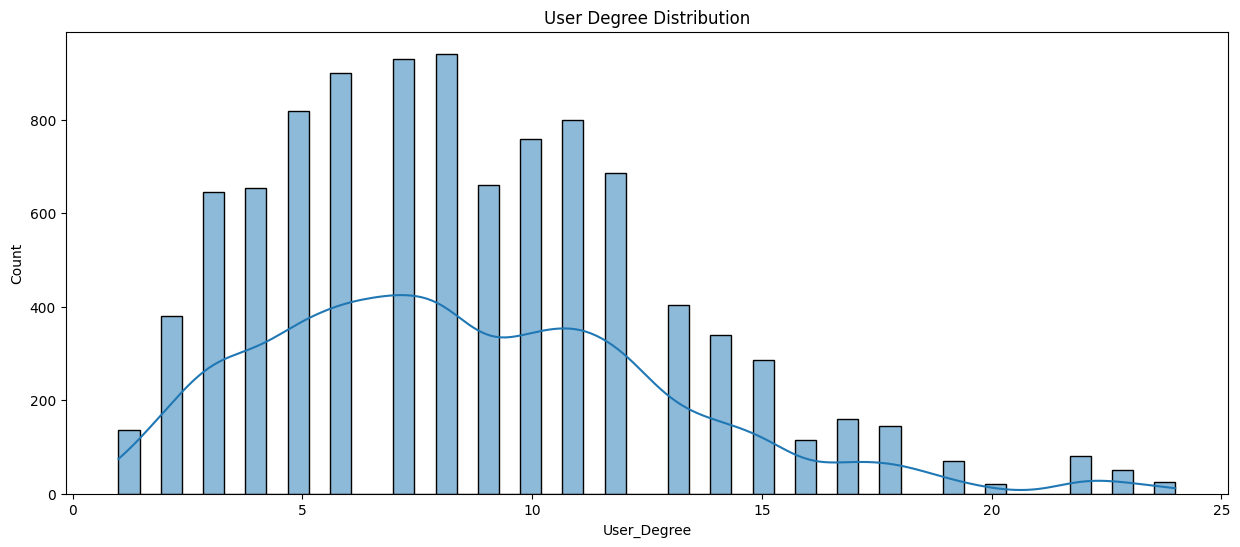

In [42]:
# Node degree distributions
sns.histplot(df['User_Degree'], bins=50, kde=True)
plt.title("User Degree Distribution")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


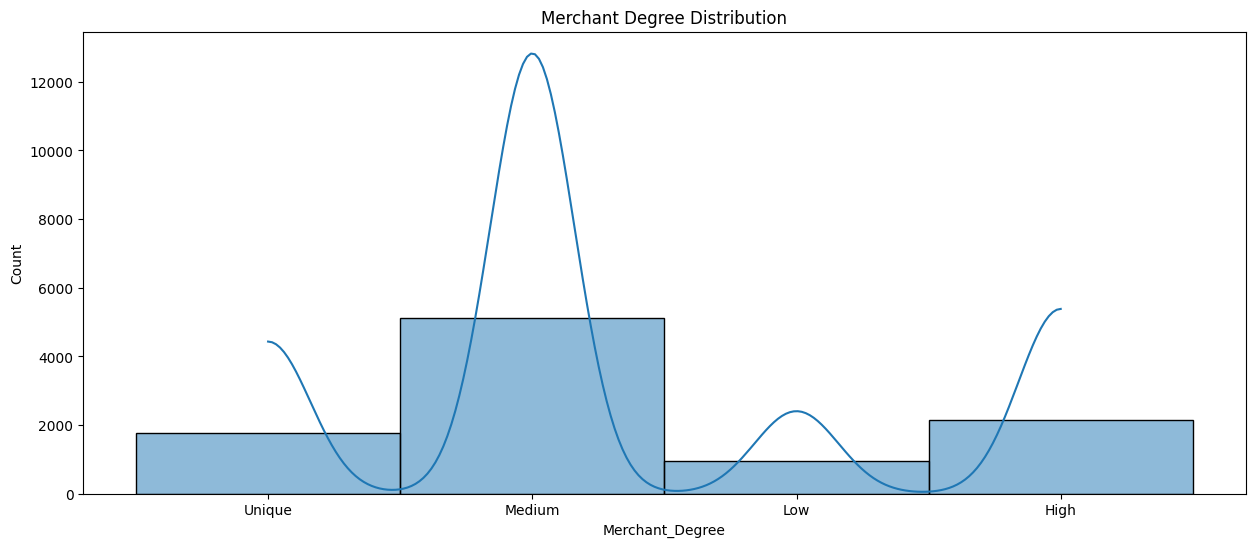

In [43]:
sns.histplot(df['Merchant_Degree'], bins=50, kde=True)
plt.title("Merchant Degree Distribution")
plt.show()

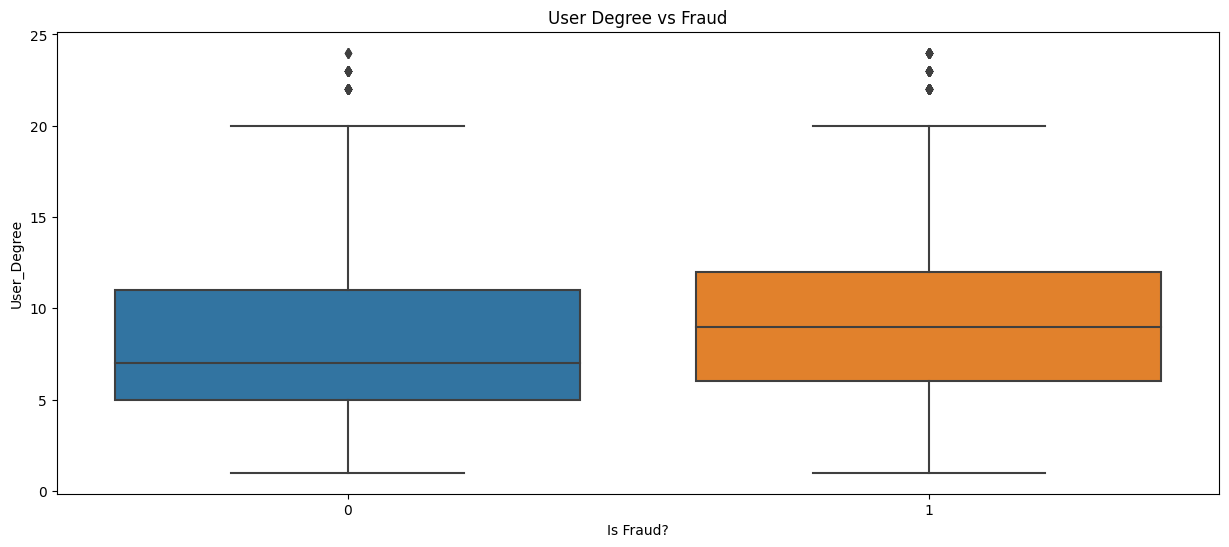

In [44]:
sns.boxplot(x='Is Fraud?', y='User_Degree', data=df)
plt.title("User Degree vs Fraud")
plt.show()

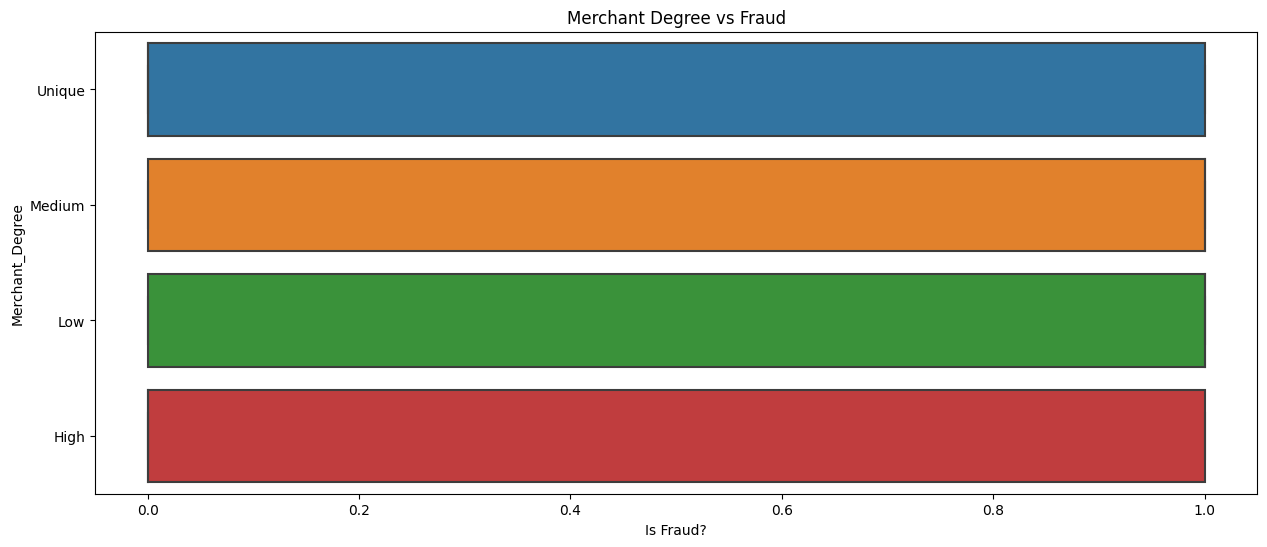

In [45]:
sns.boxplot(x='Is Fraud?', y='Merchant_Degree', data=df)
plt.title("Merchant Degree vs Fraud")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


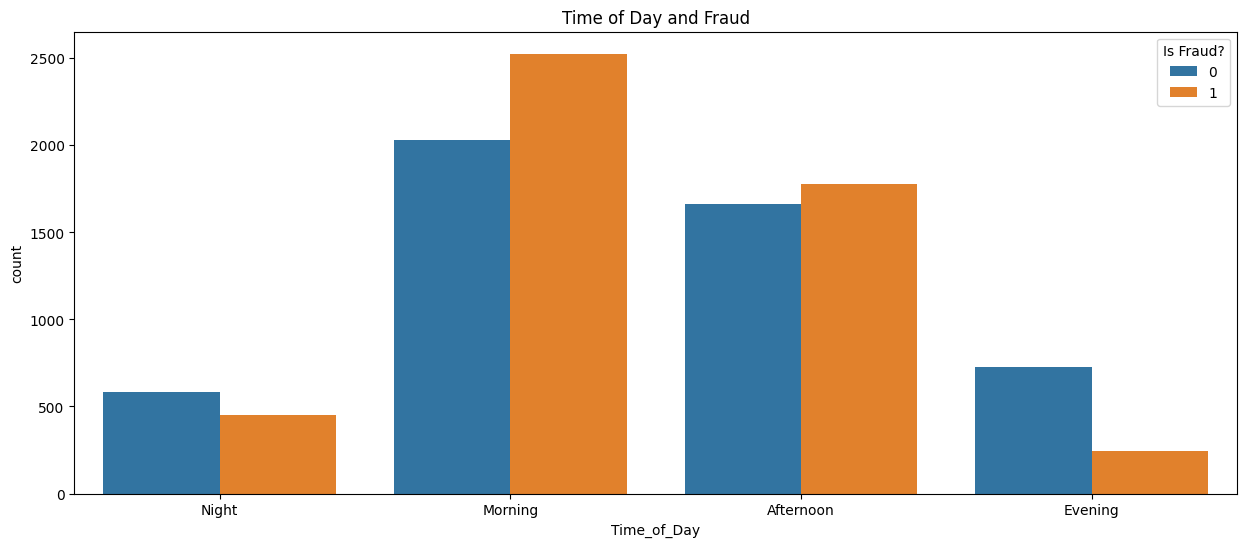

In [46]:
sns.countplot(x='Time_of_Day', hue='Is Fraud?', data=df)
plt.title("Time of Day and Fraud")
plt.show()

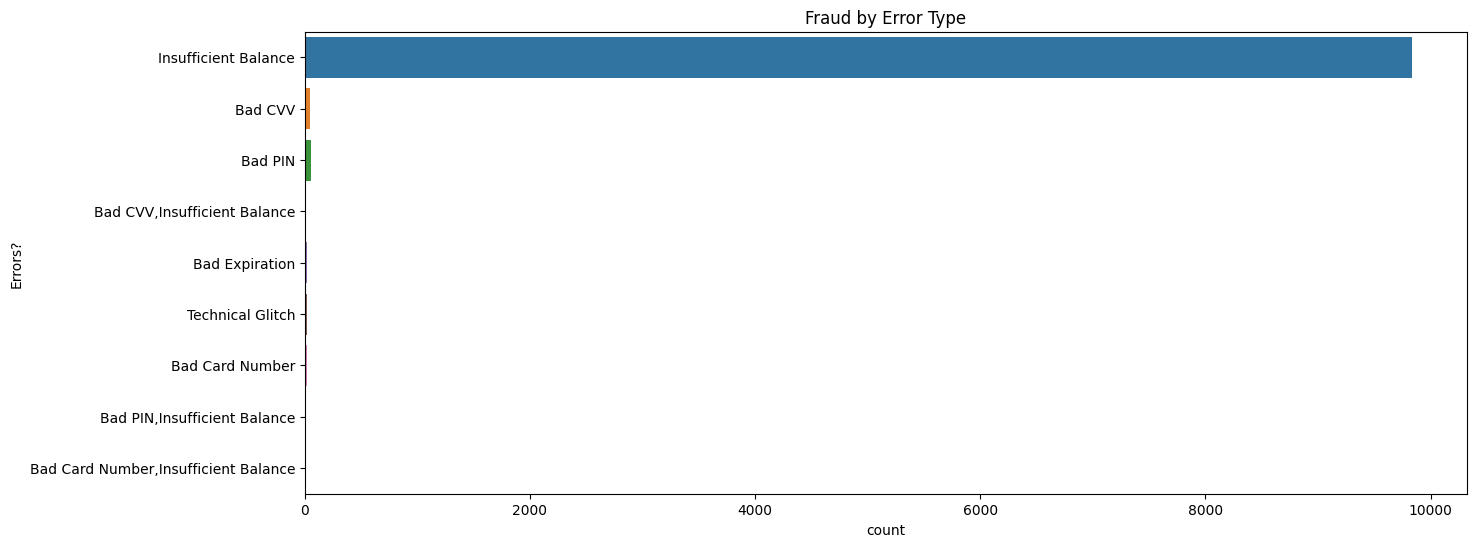

In [47]:
# Error analysis
sns.countplot(y='Errors?', data=df)
plt.title("Fraud by Error Type")
plt.show()

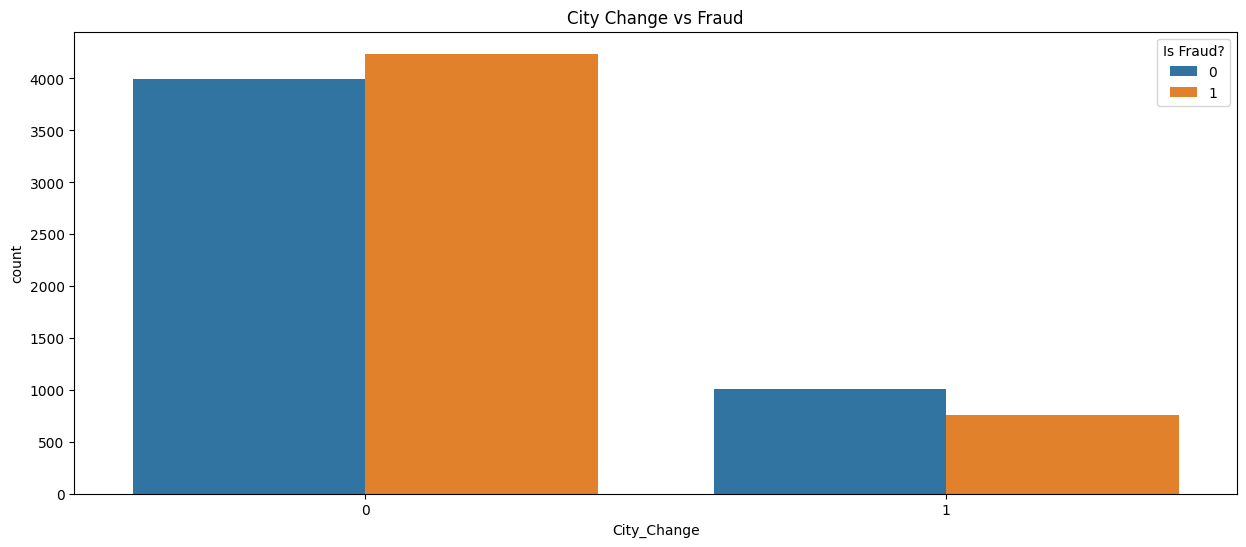

In [48]:
sns.countplot(x='City_Change', hue='Is Fraud?', data=df)
plt.title("City Change vs Fraud")
plt.show()

In [49]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,DateTime,Hour,Date,User_Date,Merchant_Date,User_Freq_Day,Merchant_Freq_Day,Time_Diff_Hours,Log_Amount,User_Avg_Amount,Amount_Deviation,Prev_City,City_Change,Day_of_Week,Is_Weekend,Time_of_Day,User_Degree,Merchant_Degree
752,0,0,2004,5,24,11:27,2.30,2,-34551508091458520,20,CA,91750.0,5912,Insufficient Balance,0,2004-05-24 11:27:00,11,2004-05-24,0_2004-05-24,-34551508091458520_2004-05-24,1,1,0.000000,1.193922,92.105714,-89.805714,other,1,0,0,Morning,6,Unique
4753,0,3,2006,4,16,05:24,128.35,2,5817218446178736267,20,CA,91750.0,5912,Insufficient Balance,0,2006-04-16 05:24:00,5,2006-04-16,0_2006-04-16,5817218446178736267_2006-04-16,1,1,16601.950000,4.862522,92.105714,36.244286,other,0,6,1,Night,6,Medium
3059,0,3,2008,1,25,06:18,149.12,2,4060646732831064559,20,CA,91750.0,5411,Insufficient Balance,0,2008-01-25 06:18:00,6,2008-01-25,0_2008-01-25,4060646732831064559_2008-01-25,1,1,15576.900000,5.011435,92.105714,57.014286,other,0,4,0,Night,6,Unique
1558,0,3,2008,10,12,15:54,96.19,2,3189517333335617109,20,CA,91750.0,5311,Insufficient Balance,1,2008-10-12 15:54:00,15,2008-10-12,0_2008-10-12,3189517333335617109_2008-10-12,1,1,6273.600000,4.576668,92.105714,4.084286,other,0,6,1,Afternoon,6,Medium
2062,0,0,2013,9,14,09:55,71.56,2,3952145593743244256,20,CA,91750.0,7538,Insufficient Balance,0,2013-09-14 09:55:00,9,2013-09-14,0_2013-09-14,3952145593743244256_2013-09-14,1,1,43146.016667,4.284414,92.105714,-20.545714,other,0,5,1,Morning,6,Low


In [50]:
cols=["Merchant State","Prev_City","Time_of_Day","Errors?"]
mappings = {}

for col in cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    # Save mapping for this column
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Now print mappings for all columns
for col, mapping in mappings.items():
    print(f"\nMapping for column '{col}':")
    print("#################################################################################")
    for category, code in mapping.items():
        
        print(f"  {category} => {code}")


Mapping for column 'Merchant State':
#################################################################################
  AK => 0
  AL => 1
  AR => 2
  AZ => 3
  Algeria => 4
  CA => 5
  CO => 6
  CT => 7
  Canada => 8
  China => 9
  Costa Rica => 10
  DC => 11
  DE => 12
  Dominican Republic => 13
  FL => 14
  Fiji => 15
  Finland => 16
  France => 17
  GA => 18
  Germany => 19
  HI => 20
  Haiti => 21
  IA => 22
  ID => 23
  IL => 24
  IN => 25
  India => 26
  Ireland => 27
  Israel => 28
  Italy => 29
  Japan => 30
  KS => 31
  KY => 32
  LA => 33
  MA => 34
  MD => 35
  ME => 36
  MI => 37
  MN => 38
  MO => 39
  MS => 40
  MT => 41
  Mexico => 42
  NC => 43
  ND => 44
  NE => 45
  NH => 46
  NJ => 47
  NM => 48
  NV => 49
  NY => 50
  Nigeria => 51
  OH => 52
  OK => 53
  OR => 54
  PA => 55
  RI => 56
  SC => 57
  SD => 58
  Sweden => 59
  TN => 60
  TX => 61
  Turkey => 62
  Tuvalu => 63
  UT => 64
  United Kingdom => 65
  VA => 66
  VT => 67
  WA => 68
  WI => 69
  WV => 70
  W

In [51]:
df.drop(columns=['Year', 'Month', 'Day', 'Time', 'Date', 'User_Date', 'Merchant_Date',"DateTime"],axis=1, inplace=True)


In [52]:
df.head()

,User,Card,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,User_Freq_Day,Merchant_Freq_Day,Time_Diff_Hours,Log_Amount,User_Avg_Amount,Amount_Deviation,Prev_City,City_Change,Day_of_Week,Is_Weekend,Time_of_Day,User_Degree,Merchant_Degree
752,0,0,2.30,2,-34551508091458520,20,5,91750.0,5912,7,0,11,1,1,0.000000,1.193922,92.105714,-89.805714,20,1,0,0,2,6,Unique
4753,0,3,128.35,2,5817218446178736267,20,5,91750.0,5912,7,0,5,1,1,16601.950000,4.862522,92.105714,36.244286,20,0,6,1,3,6,Medium
3059,0,3,149.12,2,4060646732831064559,20,5,91750.0,5411,7,0,6,1,1,15576.900000,5.011435,92.105714,57.014286,20,0,4,0,3,6,Unique
1558,0,3,96.19,2,3189517333335617109,20,5,91750.0,5311,7,1,15,1,1,6273.600000,4.576668,92.105714,4.084286,20,0,6,1,0,6,Medium
2062,0,0,71.56,2,3952145593743244256,20,5,91750.0,7538,7,0,9,1,1,43146.016667,4.284414,92.105714,-20.545714,20,0,5,1,2,6,Low


In [53]:
merchant_degree_mapping = {
    "Unique": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Extreme": 4
}
df['Merchant_Degree'] = df['Merchant_Degree'].map(merchant_degree_mapping)

In [54]:
mean=df["Log_Amount"].mean()
df["Log_Amount"]=df["Log_Amount"].fillna(mean)

In [55]:
# X=df.drop(columns=["Is Fraud?"],axis=1)
# y=df["Is Fraud?"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [56]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

In [57]:
# importances = pd.Series(model.feature_importances_, index=X.columns)
# top7 = importances.sort_values(ascending=False).head(7)
# top7.sort_values().plot(kind='barh')
# plt.title("Top 7 Important Features for Fraud Detection")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

| Merchant State Code          | Code |
|----------------------------|------|
| AK                         | 0    |
| AL                         | 1    |
| AR                         | 2    |
| AZ                         | 3    |
| Algeria                    | 4    |
| Antigua and Barbuda        | 5    |
| Argentina                  | 6    |
| Aruba                      | 7    |
| Australia                  | 8    |
| Austria                    | 9    |
| Azerbaijan                 | 10   |
| Bahrain                    | 11   |
| Bangladesh                 | 12   |
| Barbados                   | 13   |
| Belarus                    | 14   |
| Belgium                    | 15   |
| Belize                     | 16   |
| Bosnia and Herzegovina     | 17   |
| Brazil                     | 18   |
| CA                         | 19   |
| CO                         | 20   |
| CT                         | 21   |
| Cabo Verde                 | 22   |
| Cambodia                   | 23   |
| Canada                     | 24   |
| Central African Republic   | 25   |
| Chile                      | 26   |
| China                      | 27   |
| Colombia                   | 28   |
| Costa Rica                 | 29   |
| Cote d'Ivoire              | 30   |
| Croatia                    | 31   |
| Czech Republic             | 32   |
| DC                         | 33   |
| DE                         | 34   |
| Denmark                    | 35   |
| Dominica                   | 36   |
| Dominican Republic         | 37   |
| East Timor (Timor-Leste)   | 38   |
| Ecuador                    | 39   |
| Egypt                      | 40   |
| Eritrea                    | 41   |
| Estonia                    | 42   |
| FL                         | 43   |
| Fiji                       | 44   |
| Finland                    | 45   |
| France                     | 46   |
| GA                         | 47   |
| Georgia                    | 48   |
| Germany                    | 49   |
| Ghana                      | 50   |
| Greece                     | 51   |
| Guatemala                  | 52   |
| Guyana                     | 53   |
| HI                         | 54   |
| Haiti                      | 55   |
| Honduras                   | 56   |
| Hong Kong                  | 57   |
| Hungary                    | 58   |
| IA                         | 59   |
| ID                         | 60   |
| IL                         | 61   |
| IN                         | 62   |
| Iceland                    | 63   |
| India                      | 64   |
| Indonesia                  | 65   |
| Ireland                    | 66   |
| Israel                     | 67   |
| Italy                      | 68   |
| Jamaica                    | 69   |
| Japan                      | 70   |
| Jordan                     | 71   |
| KS                         | 72   |
| KY                         | 73   |
| Kenya                      | 74   |
| Kosovo                     | 75   |
| Kuwait                     | 76   |
| LA                         | 77   |
| Latvia                     | 78   |
| Lebanon                    | 79   |
| Liberia                    | 80   |
| Lithuania                  | 81   |
| Luxembourg                 | 82   |
| MA                         | 83   |
| MD                         | 84   |
| ME                         | 85   |
| MI                         | 86   |
| MN                         | 87   |
| MO                         | 88   |
| MS                         | 89   |
| MT                         | 90   |
| Macedonia                  | 91   |
| Malaysia                   | 92   |
| Malta                      | 93   |
| Mexico                     | 94   |
| Moldova                    | 95   |
| Monaco                     | 96   |
| Morocco                    | 97   |
| Mozambique                 | 98   |
| Myanmar (Burma)            | 99   |
| NC                         | 100  |
| ND                         | 101  |
| NE                         | 102  |
| NH                         | 103  |
| NJ                         | 104  |
| NM                         | 105  |
| NV                         | 106  |
| NY                         | 107  |
| Nauru                      | 108  |
| Netherlands                | 109  |
| New Zealand                | 110  |
| Nicaragua                  | 111  |
| Niger                      | 112  |
| Nigeria                    | 113  |
| Norway                     | 114  |
| OH                         | 115  |
| OK                         | 116  |
| OR                         | 117  |
| Oman                       | 118  |
| PA                         | 119  |
| Pakistan                   | 120  |
| Panama                     | 121  |
| Peru                       | 122  |
| Philippines                | 123  |
| Poland                     | 124  |
| Portugal                   | 125  |
| RI                         | 126  |
| Romania                    | 127  |
| Russia                     | 128  |
| SC                         | 129  |
| SD                         | 130  |
| Saudi Arabia               | 131  |
| Senegal                    | 132  |
| Serbia                     | 133  |
| Seychelles                 | 134  |
| Singapore                  | 135  |
| Slovakia                   | 136  |
| Slovenia                   | 137  |
| Somalia                    | 138  |
| South Africa               | 139  |
| South Korea                | 140  |
| Spain                      | 141  |
| Sri Lanka                  | 142  |
| Sudan                      | 143  |
| Suriname                   | 144  |
| Sweden                     | 145  |
| Switzerland                | 146  |
| Syria                      | 147  |
| TN                         | 148  |
| TX                         | 149  |
| Taiwan                     | 150  |
| Thailand                   | 151  |
| The Bahamas                | 152  |
| Tunisia                    | 153  |
| Turkey                     | 154  |
| Tuvalu                     | 155  |
| UT                         | 156  |
| Uganda                     | 157  |
| Ukraine                    | 158  |
| United Arab Emirates       | 159  |
| United Kingdom             | 160  |
| Uruguay                    | 161  |
| Uzbekistan                 | 162  |
| VA                         | 163  |
| VT                         | 164  |
| Vatican City               | 165  |
| Vietnam                    | 166  |
| WA                         | 167  |
| WI                         | 168  |
| WV                         | 169  |
| WY                         | 170  |
| Yemen                      | 171  |
| Zimbabwe                   | 172  |


### 🏙️ Merchant City Code Mapping

| Merchant City     | Code |
|-------------------|------|
| Atlanta           | 0    |
| Bronx             | 1    |
| Brooklyn          | 2    |
| Chicago           | 3    |
| Dallas            | 4    |
| Houston           | 5    |
| Indianapolis      | 6    |
| Las Vegas         | 7    |
| Los Angeles       | 8    |
| Louisville        | 9    |
| Miami             | 10   |
| Minneapolis       | 11   |
| New York          | 12   |
| ONLINE            | 13   |
| Orlando           | 14   |
| Philadelphia      | 15   |
| San Antonio       | 16   |
| San Diego         | 17   |
| San Francisco     | 18   |
| Tucson            | 19   |
| other             | 20   |


In [58]:
# top7_features = top7.index.tolist()
# df = X[top7_features].copy()
# df["Is Fraud?"] = y
# df = df.reset_index(drop=True)
# df.to_csv("fraud_top7_features.csv", index=False)

In [59]:
df=pd.read_csv("/kaggle/input/custom-image-dataset/fraud_top7_features.csv")

In [60]:
df.rename(columns={
    "Zip": "Zipcode",
    "Merchant State": "Merchant_State_Code",
    "User_Freq_Day": "User_Frequency_Per_Day",
    "Time_Diff_Hours": "Time_Difference_Hours",
    "MCC": "Merchant_Category_Code",
    "Merchant City": "Merchant_City_Code",
    "Amount": "Transaction_Amount",
    "Is Fraud?": "Is_Fraud"
}, inplace=True)


### 📘 Feature Descriptions Table

| Feature Name                | Description                                                                 |
|----------------------------|-----------------------------------------------------------------------------|
| `Zipcode`                  | Postal code where the transaction occurred.                                |
| `Merchant_State_Code`      | Encoded value representing the merchant’s state.                           |
| `User_Frequency_Per_Day`   | Number of transactions made by the user on that day.                       |
| `Time_Difference_Hours`    | Time difference (in hours) since the user's previous transaction.          |
| `Merchant_Category_Code`   | Encoded merchant category (e.g., groceries, fuel, electronics, etc.).      |
| `Merchant_City_Code`       | Encoded city where the merchant is located.                                |
| `Transaction_Amount`       | The amount of money involved in the transaction.                           |
| `Is_Fraud`                 | Target variable — 1 indicates fraud, 0 indicates non-fraud.                |


In [61]:
df.head()

,Zipcode,Merchant_State_Code,User_Frequency_Per_Day,Time_Difference_Hours,Merchant_Category_Code,Merchant_City_Code,Transaction_Amount,Is_Fraud
0,91750.0,5,1,0.000000,5912,20,2.30,0
1,91750.0,5,1,16601.950000,5912,20,128.35,0
2,91750.0,5,1,15576.900000,5411,20,149.12,0
3,91750.0,5,1,6273.600000,5311,20,96.19,1
4,91750.0,5,1,43146.016667,7538,20,71.56,0


In [62]:
from sklearn.preprocessing import MinMaxScaler
features_to_scale = [
    
    "Zipcode",
   
    "Time_Difference_Hours",
    "Merchant_Category_Code",
    "Transaction_Amount"
]
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [63]:
# Select 2500 fraud samples
fraud_df = df[df["Is_Fraud"] == 1].sample(n=1500, random_state=42)

# Select 2500 non-fraud samples
nonfraud_df = df[df["Is_Fraud"] == 0].sample(n=1500, random_state=42)

# Combine and shuffle
df = pd.concat([fraud_df, nonfraud_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,Zipcode,Merchant_State_Code,User_Frequency_Per_Day,Time_Difference_Hours,Merchant_Category_Code,Merchant_City_Code,Transaction_Amount,Is_Fraud
0,0.949859,5,1,0.001660,0.757639,20,0.156691,0
1,0.504828,29,1,0.192141,0.467950,20,0.146136,1
2,0.975404,54,1,0.062189,0.533481,20,0.146765,0
3,0.504828,5,2,0.000000,0.468080,13,0.355316,1
4,0.277125,43,1,0.157428,0.414640,20,0.172727,0


In [64]:
# Create node feature matrix (preprocessed)
node_features = torch.tensor(df[['User_Frequency_Per_Day', 'Time_Difference_Hours', 
                                'Merchant_State_Code', 'Merchant_Category_Code', 
                                'Zipcode', 'Merchant_City_Code', 
                                'Transaction_Amount']].values, dtype=torch.float)

In [65]:
from tqdm import tqdm
import torch

# Initialize edge list
edge_index = []

# Outer loop with tqdm for progress monitoring
for i in tqdm(range(len(df)), desc="Building edge index by Zipcode"):
    for j in range(i + 1, len(df)):
        if df['Zipcode'].iloc[i] == df['Zipcode'].iloc[j]:
            edge_index.append([i, j])
            edge_index.append([j, i])  # Undirected graph

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t()

Building edge index by Zipcode: 100%|██████████| 3000/3000 [00:52<00:00, 56.89it/s] 


In [66]:
# Labels
labels = torch.tensor(df['Is_Fraud'].values, dtype=torch.float)

In [67]:
n_nodes = len(df)
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
indices = list(range(n_nodes))
random.shuffle(indices)
train_size = int(0.8 * n_nodes)
train_indices = indices[:train_size]
val_indices = indices[train_size:]
train_mask[train_indices] = True
val_mask[val_indices] = True

In [68]:
# Create PyG Data object
graph_data = Data(x=node_features, edge_index=edge_index, y=labels, 
                 train_mask=train_mask, val_mask=val_mask)

In [69]:
# Define GNN model
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FraudGNN, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=0.3)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return torch.sigmoid(x).squeeze()  # Squeeze for shape [N]


# Initialize model, optimizer, and loss
input_dim = node_features.shape[1]  # 7 features
model = FraudGNN(input_dim=input_dim, hidden_dim=16, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
graph_data = graph_data.to(device)


In [71]:
import torch.nn.functional as F

epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []
headers = ["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc"]
print("\nTraining Metrics:")
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    optimizer.zero_grad()
    model.train()
    out = model(graph_data).squeeze()
    
    # Training loss and accuracy
    train_pred = out[train_mask]
    train_labels = graph_data.y[train_mask]
    train_loss = criterion(train_pred, train_labels)
    train_pred_binary = (train_pred > 0.5).float()
    train_acc = accuracy_score(train_labels.cpu().numpy(), train_pred_binary.cpu().numpy())
    
    # Validation loss and accuracy
    val_pred = out[val_mask]
    val_labels = graph_data.y[val_mask]
    val_loss = criterion(val_pred, val_labels)
    val_pred_binary = (val_pred > 0.5).float()
    val_acc = accuracy_score(val_labels.cpu().numpy(), val_pred_binary.cpu().numpy())
    
    # Backpropagation
    train_loss.backward()
    optimizer.step()
    
    # Store metrics for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Display metrics for current epoch
    print(tabulate([[epoch + 1, train_loss.item(), val_loss.item(), train_acc, val_acc]], 
                   headers=headers, tablefmt="grid", floatfmt=".4f"))
    
    # Clear GPU memory
    if device.type == 'cuda':
        torch.cuda.empty_cache()


Training Metrics:


Training Epochs:   4%|▍         | 2/50 [00:00<00:13,  3.54it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       1 |       0.9823 |     1.0922 |      0.7321 |    0.7167 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       2 |       0.6397 |     0.5833 |      0.8213 |    0.8517 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:   8%|▊         | 4/50 [00:00<00:08,  5.27it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       3 |       1.2733 |     1.1777 |      0.4929 |    0.5000 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       4 |       0.7724 |     0.6862 |      0.8446 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  12%|█▏        | 6/50 [00:01<00:07,  6.10it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       5 |       0.6326 |     0.5632 |      0.8404 |    0.8500 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       6 |       0.5795 |     0.6010 |      0.8333 |    0.8300 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  16%|█▌        | 8/50 [00:01<00:06,  6.53it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       7 |       0.5842 |     0.5453 |      0.8017 |    0.8217 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       8 |       0.6434 |     0.6857 |      0.7604 |    0.7800 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  20%|██        | 10/50 [00:01<00:05,  6.75it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|       9 |       0.7097 |     0.6787 |      0.7738 |    0.7900 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      10 |       0.5756 |     0.5441 |      0.7937 |    0.8150 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  24%|██▍       | 12/50 [00:02<00:05,  6.85it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      11 |       0.5376 |     0.4892 |      0.8163 |    0.8433 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      12 |       0.5218 |     0.5366 |      0.8300 |    0.8317 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  28%|██▊       | 14/50 [00:02<00:05,  6.91it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      13 |       0.5837 |     0.5431 |      0.8337 |    0.8400 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      14 |       0.5135 |     0.4973 |      0.8346 |    0.8417 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  32%|███▏      | 16/50 [00:02<00:04,  6.93it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      15 |       0.5233 |     0.5107 |      0.8300 |    0.8417 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      16 |       0.5443 |     0.5457 |      0.8317 |    0.8383 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  36%|███▌      | 18/50 [00:02<00:04,  6.95it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      17 |       0.5083 |     0.5210 |      0.8358 |    0.8400 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      18 |       0.4935 |     0.4609 |      0.8267 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  40%|████      | 20/50 [00:03<00:04,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      19 |       0.4952 |     0.4921 |      0.8246 |    0.8367 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      20 |       0.4980 |     0.4503 |      0.8254 |    0.8500 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  44%|████▍     | 22/50 [00:03<00:04,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      21 |       0.4965 |     0.4882 |      0.8237 |    0.8217 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      22 |       0.4740 |     0.4757 |      0.8408 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  48%|████▊     | 24/50 [00:03<00:03,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      23 |       0.5005 |     0.4660 |      0.8325 |    0.8433 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      24 |       0.4736 |     0.4429 |      0.8413 |    0.8600 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  52%|█████▏    | 26/50 [00:04<00:03,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      25 |       0.4857 |     0.4584 |      0.8425 |    0.8567 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      26 |       0.4654 |     0.4677 |      0.8483 |    0.8600 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  56%|█████▌    | 28/50 [00:04<00:03,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      27 |       0.4690 |     0.4503 |      0.8475 |    0.8500 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      28 |       0.4650 |     0.4315 |      0.8475 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  60%|██████    | 30/50 [00:04<00:02,  6.95it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      29 |       0.4722 |     0.4624 |      0.8417 |    0.8517 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      30 |       0.4967 |     0.4775 |      0.8400 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  64%|██████▍   | 32/50 [00:04<00:02,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      31 |       0.4681 |     0.4439 |      0.8425 |    0.8533 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      32 |       0.4707 |     0.4430 |      0.8433 |    0.8650 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  68%|██████▊   | 34/50 [00:05<00:02,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      33 |       0.4718 |     0.4550 |      0.8433 |    0.8500 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      34 |       0.4582 |     0.4682 |      0.8488 |    0.8500 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  72%|███████▏  | 36/50 [00:05<00:02,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      35 |       0.4632 |     0.4725 |      0.8417 |    0.8500 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      36 |       0.4661 |     0.4723 |      0.8450 |    0.8533 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  76%|███████▌  | 38/50 [00:05<00:01,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      37 |       0.4587 |     0.4317 |      0.8467 |    0.8583 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      38 |       0.4644 |     0.4472 |      0.8471 |    0.8633 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  80%|████████  | 40/50 [00:06<00:01,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      39 |       0.4660 |     0.4427 |      0.8454 |    0.8600 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      40 |       0.4548 |     0.4332 |      0.8467 |    0.8567 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  84%|████████▍ | 42/50 [00:06<00:01,  6.95it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      41 |       0.4596 |     0.4422 |      0.8488 |    0.8583 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      42 |       0.4643 |     0.4461 |      0.8471 |    0.8617 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  88%|████████▊ | 44/50 [00:06<00:00,  6.95it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      43 |       0.4627 |     0.4672 |      0.8467 |    0.8583 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      44 |       0.4539 |     0.4451 |      0.8475 |    0.8550 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  92%|█████████▏| 46/50 [00:06<00:00,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      45 |       0.4582 |     0.4373 |      0.8475 |    0.8550 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      46 |       0.4468 |     0.4495 |      0.8488 |    0.8550 |
+---------+--------------+------------+-------------+-----------+


Training Epochs:  96%|█████████▌| 48/50 [00:07<00:00,  6.96it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      47 |       0.4648 |     0.4409 |      0.8429 |    0.8567 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      48 |       0.4451 |     0.4509 |      0.8479 |    0.8567 |
+---------+--------------+------------+-------------+-----------+


Training Epochs: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]

+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      49 |       0.4471 |     0.4461 |      0.8458 |    0.8567 |
+---------+--------------+------------+-------------+-----------+
+---------+--------------+------------+-------------+-----------+
|   Epoch |   Train Loss |   Val Loss |   Train Acc |   Val Acc |
+=========+==============+============+=============+===========+
|      50 |       0.4520 |     0.4303 |      0.8475 |    0.8583 |
+---------+--------------+------------+-------------+-----------+


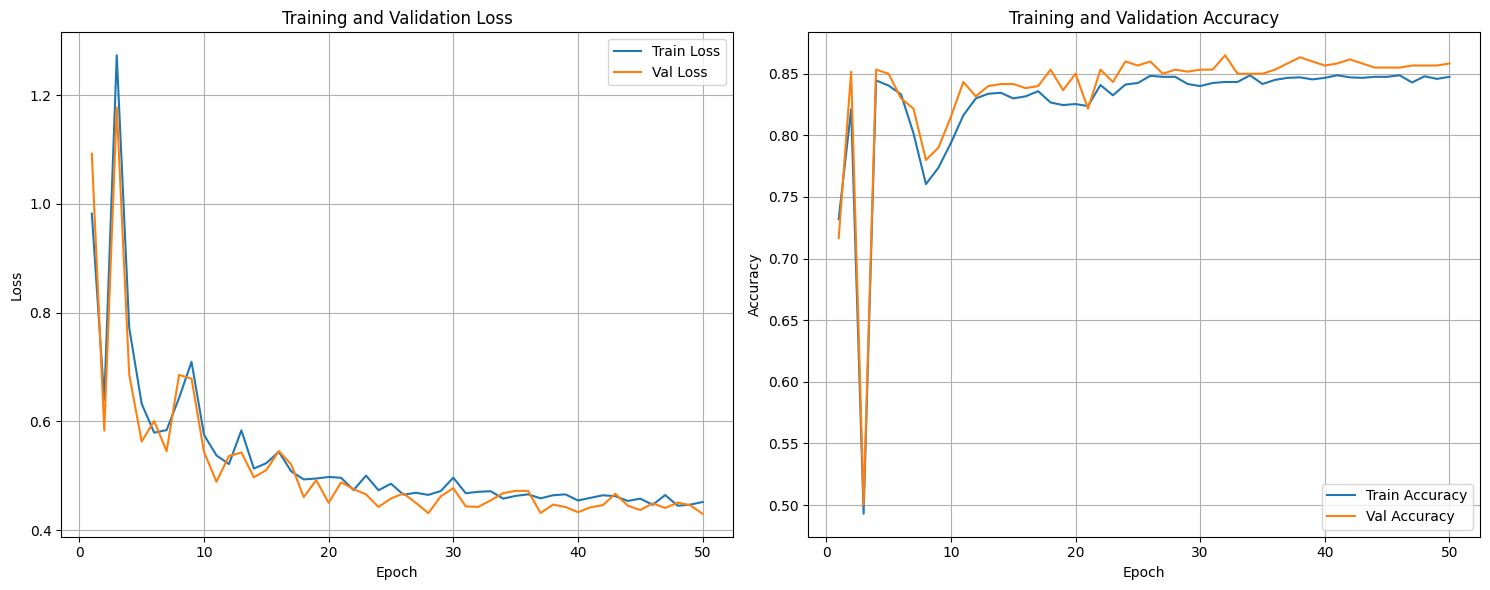

In [72]:
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [73]:

def evaluate_model(model, data, mask, set_name="Set", threshold=0.5):
    model.eval()
    with torch.no_grad():
        out = model(data).squeeze()
        pred = out[mask]
        labels = data.y[mask]
        pred_binary = (pred > threshold).float()
        
        # Move to CPU for sklearn metrics
        pred_binary_np = pred_binary.cpu().numpy()
        labels_np = labels.cpu().numpy()
        pred_proba_np = pred.cpu().numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(labels_np, pred_binary_np)
        precision = precision_score(labels_np, pred_binary_np, zero_division=0)
        recall = recall_score(labels_np, pred_binary_np, zero_division=0)
        f1 = f1_score(labels_np, pred_binary_np, zero_division=0)
        roc_auc = roc_auc_score(labels_np, pred_proba_np) if len(np.unique(labels_np)) > 1 else 0.0
        
        # Prepare and print metrics table
        metrics = [
            ["Accuracy", accuracy],
            ["Precision", precision],
            ["Recall", recall],
            ["F1-Score", f1],
            ["ROC-AUC", roc_auc]
        ]
        
        print(f"\n{set_name} Metrics (Threshold = {threshold:.4f}):")
        print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid", floatfmt=".4f"))
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'pred_proba': pred_proba_np,
            'labels': labels_np
        }

# Evaluate with multiple thresholds
thresholds = [0.5, 0.4, 0.3]
print("\nInitial Model Evaluation with Multiple Thresholds:")
train_metrics_list = []
val_metrics_list = []

for threshold in thresholds:
    print(f"\nEvaluating with Threshold = {threshold:.4f}")
    train_metrics = evaluate_model(model, graph_data, train_mask, "Training", threshold=threshold)
    val_metrics = evaluate_model(model, graph_data, val_mask, "Validation", threshold=threshold)
    train_metrics_list.append(train_metrics)
    val_metrics_list.append(val_metrics)

# Use threshold 0.5 for subsequent cells
train_metrics = train_metrics_list[0]  # Metrics with threshold 0.5
val_metrics = val_metrics_list[0]      # Metrics with threshold 0.5


Initial Model Evaluation with Multiple Thresholds:

Evaluating with Threshold = 0.5000

Training Metrics (Threshold = 0.5000):
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.4971 |
+-----------+---------+
| Precision |  0.0000 |
+-----------+---------+
| Recall    |  0.0000 |
+-----------+---------+
| F1-Score  |  0.0000 |
+-----------+---------+
| ROC-AUC   |  0.8637 |
+-----------+---------+

Validation Metrics (Threshold = 0.5000):
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.5117 |
+-----------+---------+
| Precision |  0.0000 |
+-----------+---------+
| Recall    |  0.0000 |
+-----------+---------+
| F1-Score  |  0.0000 |
+-----------+---------+
| ROC-AUC   |  0.8712 |
+-----------+---------+

Evaluating with Threshold = 0.4000

Training Metrics (Threshold = 0.4000):
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.8529 |
+-----------+---------+
| Precisio


Optimal Threshold for Training: 0.4379
Optimal Threshold for Validation: 0.4379


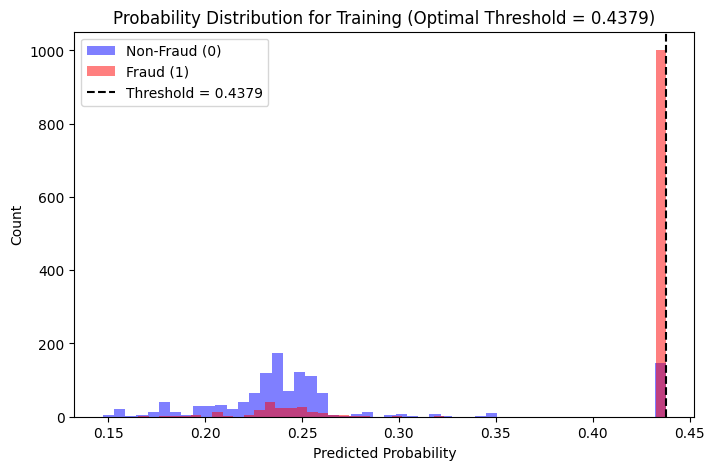

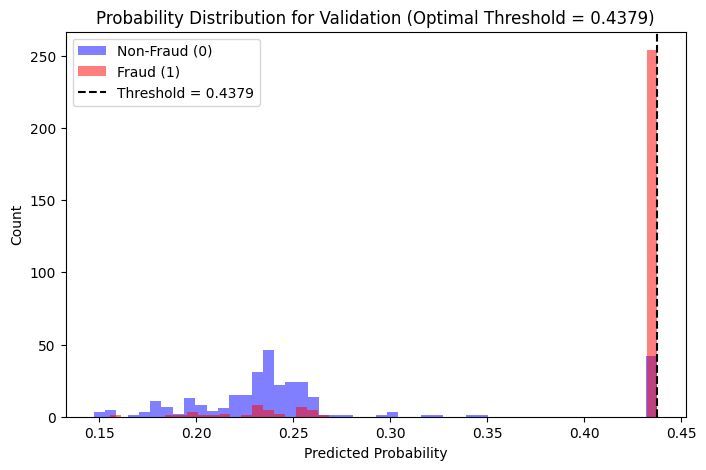

In [74]:


def calculate_optimal_threshold(pred_proba, labels):
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, pred_proba)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

def plot_probability_distribution(pred_proba, labels, set_name, threshold):
    plt.figure(figsize=(8, 5))
    plt.hist(pred_proba[labels == 0], bins=50, alpha=0.5, label='Non-Fraud (0)', color='blue')
    plt.hist(pred_proba[labels == 1], bins=50, alpha=0.5, label='Fraud (1)', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title(f'Probability Distribution for {set_name}')
    plt.legend()
    plt.show()

# Calculate optimal thresholds
train_optimal_threshold = calculate_optimal_threshold(train_metrics['pred_proba'], train_metrics['labels'])
val_optimal_threshold = calculate_optimal_threshold(val_metrics['pred_proba'], val_metrics['labels'])

print(f"\nOptimal Threshold for Training: {train_optimal_threshold:.4f}")
print(f"Optimal Threshold for Validation: {val_optimal_threshold:.4f}")

# Plot probability distributions with optimal thresholds
plot_probability_distribution(train_metrics['pred_proba'], train_metrics['labels'], 
                             f"Training (Optimal Threshold = {train_optimal_threshold:.4f})", 
                             threshold=train_optimal_threshold)
plot_probability_distribution(val_metrics['pred_proba'], val_metrics['labels'], 
                             f"Validation (Optimal Threshold = {val_optimal_threshold:.4f})", 
                             threshold=val_optimal_threshold)

In [75]:


def evaluate_model(model, data, mask, set_name="Set", threshold=0.5):
    model.eval()
    with torch.no_grad():
        out = model(data).squeeze()
        pred = out[mask]
        labels = data.y[mask]
        pred_binary = (pred > threshold).float()
        
        # Move to CPU for sklearn metrics
        pred_binary_np = pred_binary.cpu().numpy()
        labels_np = labels.cpu().numpy()
        pred_proba_np = pred.cpu().numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(labels_np, pred_binary_np)
        precision = precision_score(labels_np, pred_binary_np, zero_division=0)
        recall = recall_score(labels_np, pred_binary_np, zero_division=0)
        f1 = f1_score(labels_np, pred_binary_np, zero_division=0)
        roc_auc = roc_auc_score(labels_np, pred_proba_np) if len(np.unique(labels_np)) > 1 else 0.0
        
        # Prepare and print metrics table
        metrics = [
            ["Accuracy", accuracy],
            ["Precision", precision],
            ["Recall", recall],
            ["F1-Score", f1],
            ["ROC-AUC", roc_auc]
        ]
        
        print(f"\n{set_name} Metrics (Threshold = {threshold:.4f}):")
        print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid", floatfmt=".4f"))
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'pred_proba': pred_proba_np,
            'labels': labels_np
        }

# Re-evaluate with provided optimal thresholds
print("\nFinal Model Evaluation with Optimal Thresholds:")
train_metrics = evaluate_model(model, graph_data, train_mask, "Training", threshold=0.2788)
val_metrics = evaluate_model(model, graph_data, val_mask, "Validation", threshold=0.2796)


Final Model Evaluation with Optimal Thresholds:

Training Metrics (Threshold = 0.2788):
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.8346 |
+-----------+---------+
| Precision |  0.8364 |
+-----------+---------+
| Recall    |  0.8343 |
+-----------+---------+
| F1-Score  |  0.8353 |
+-----------+---------+
| ROC-AUC   |  0.8655 |
+-----------+---------+

Validation Metrics (Threshold = 0.2796):
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.8500 |
+-----------+---------+
| Precision |  0.8328 |
+-----------+---------+
| Recall    |  0.8669 |
+-----------+---------+
| F1-Score  |  0.8495 |
+-----------+---------+
| ROC-AUC   |  0.8743 |
+-----------+---------+


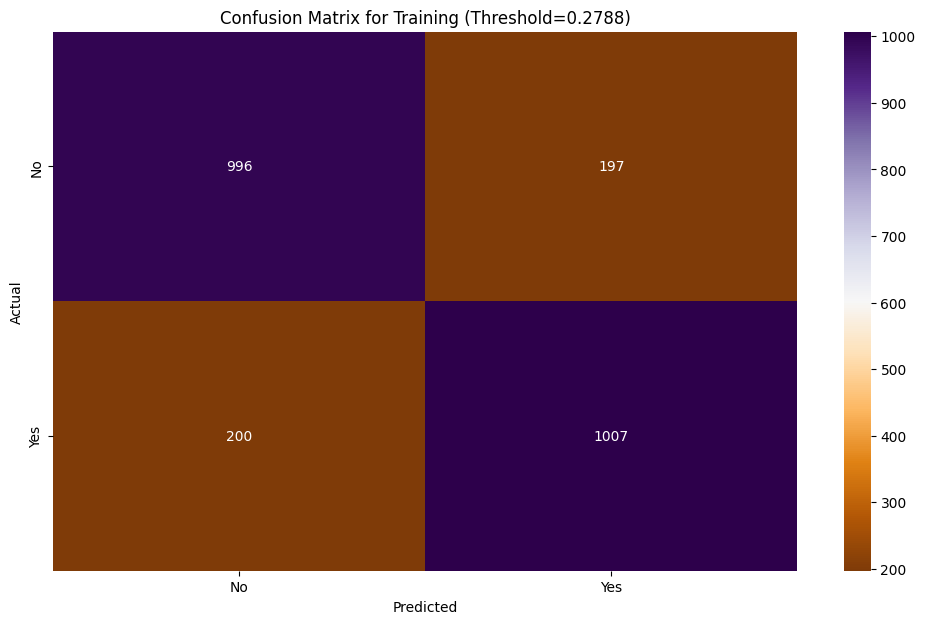

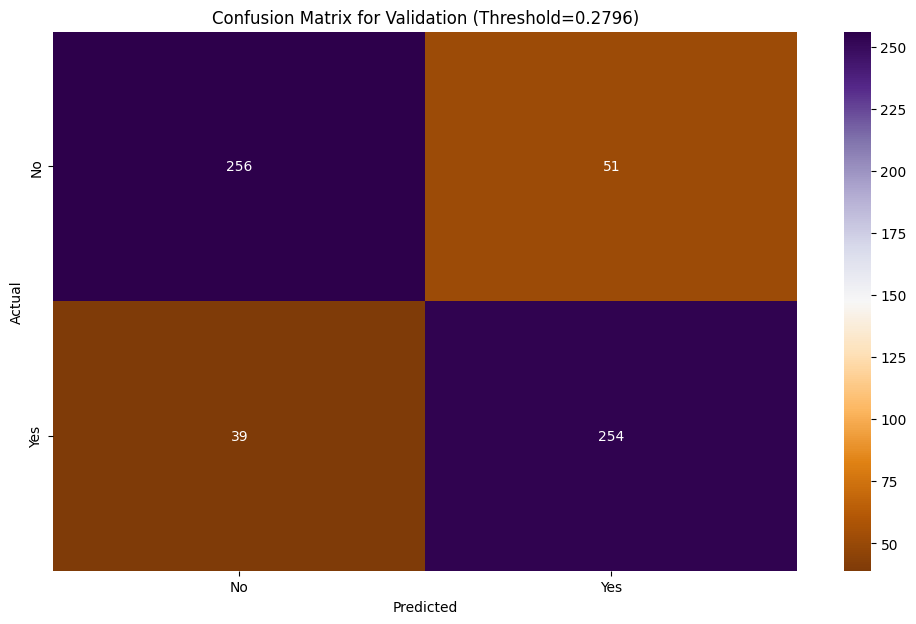

In [76]:
def plot_confusion_matrix(pred_proba, labels, threshold, set_name="Set"):
    pred_binary = (pred_proba > threshold).astype(int)
    cm = confusion_matrix(labels, pred_binary)
    
    plt.figure(figsize=(12,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="PuOr", cbar=True,xticklabels=label_name,yticklabels=label_name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {set_name} (Threshold={threshold:.4f})')
    plt.show()
    return cm

# Plot confusion matrices for train and validation
train_cm = plot_confusion_matrix(train_metrics['pred_proba'], train_metrics['labels'], 0.2788, "Training")
val_cm = plot_confusion_matrix(val_metrics['pred_proba'], val_metrics['labels'], 0.2796, "Validation")


In [77]:


def print_classification_report(pred_proba, labels, threshold, set_name="Set"):
    pred_binary = (pred_proba > threshold).astype(int)
    report = classification_report(labels, pred_binary, zero_division=0,target_names=label_name)
    print(f"\nClassification Report for {set_name} (Threshold = {threshold:.4f}):\n")
    print(report)

# Print classification reports for train and validation
print_classification_report(train_metrics['pred_proba'], train_metrics['labels'], 0.2788, "Training")
print_classification_report(val_metrics['pred_proba'], val_metrics['labels'], 0.2796, "Validation")



Classification Report for Training (Threshold = 0.2788):

              precision    recall  f1-score   support

          No       0.83      0.83      0.83      1193
         Yes       0.84      0.83      0.84      1207

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400


Classification Report for Validation (Threshold = 0.2796):

              precision    recall  f1-score   support

          No       0.87      0.83      0.85       307
         Yes       0.83      0.87      0.85       293

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



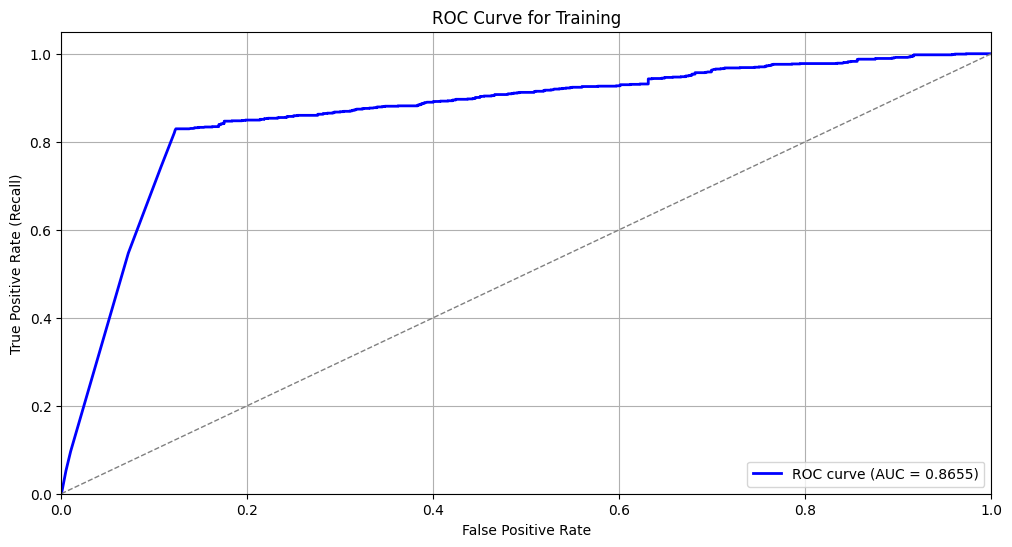

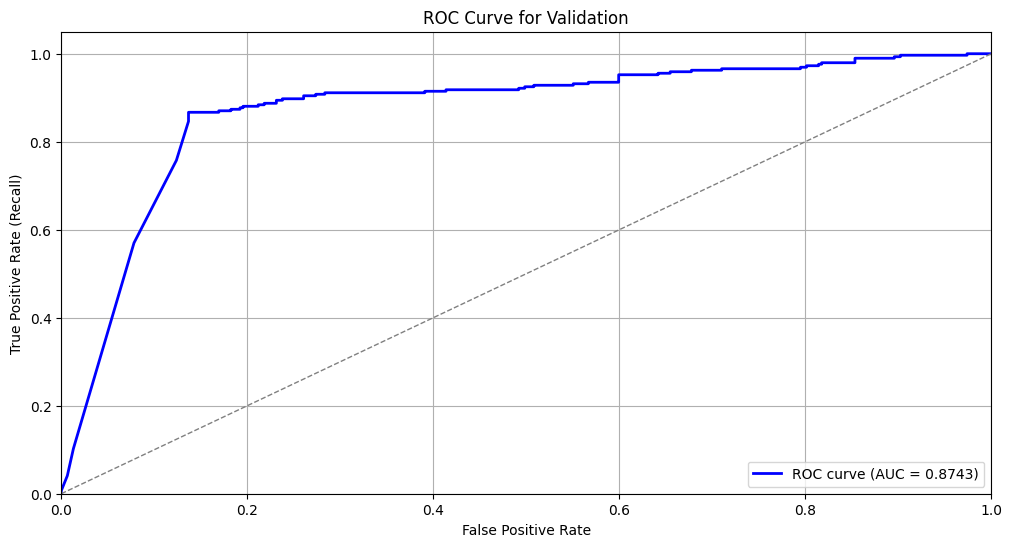

In [78]:
def plot_roc_curve(pred_proba, labels, set_name):
    fpr, tpr, thresholds = roc_curve(labels, pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(f'ROC Curve for {set_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot ROC curves
plot_roc_curve(train_metrics['pred_proba'], train_metrics['labels'], "Training")
plot_roc_curve(val_metrics['pred_proba'], val_metrics['labels'], "Validation")


In [79]:
# Sample data for reference
sample_data = pd.DataFrame({
    'Zipcode': [0.949859, 0.504828, 0.975404, 0.504828, 0.277125],
    'Merchant_State_Code': [5, 29, 54, 5, 43],
    'User_Frequency_Per_Day': [1, 1, 1, 2, 1],
    'Time_Difference_Hours': [0.001660, 0.192141, 0.062189, 0.000000, 0.157428],
    'Merchant_Category_Code': [0.757639, 0.467950, 0.533481, 0.468080, 0.414640],
    'Merchant_City_Code': [20, 20, 20, 13, 20],
    'Transaction_Amount': [0.156691, 0.146136, 0.146765, 0.355316, 0.172727]
})

# Generate 7 random transactions
np.random.seed(42)  # For reproducibility
n_samples = 7
random_data = pd.DataFrame({
    'Zipcode': np.random.uniform(sample_data['Zipcode'].min(), sample_data['Zipcode'].max(), n_samples),
    'Merchant_State_Code': np.random.randint(sample_data['Merchant_State_Code'].min(), sample_data['Merchant_State_Code'].max() + 1, n_samples),
    'User_Frequency_Per_Day': np.random.randint(sample_data['User_Frequency_Per_Day'].min(), sample_data['User_Frequency_Per_Day'].max() + 1, n_samples),
    'Time_Difference_Hours': np.random.uniform(sample_data['Time_Difference_Hours'].min(), sample_data['Time_Difference_Hours'].max(), n_samples),
    'Merchant_Category_Code': np.random.uniform(sample_data['Merchant_Category_Code'].min(), sample_data['Merchant_Category_Code'].max(), n_samples),
    'Merchant_City_Code': np.random.randint(sample_data['Merchant_City_Code'].min(), sample_data['Merchant_City_Code'].max() + 1, n_samples),
    'Transaction_Amount': np.random.uniform(sample_data['Transaction_Amount'].min(), sample_data['Transaction_Amount'].max(), n_samples)
})

# Convert to node features
node_features = torch.tensor(random_data.values, dtype=torch.float).to(device)

In [80]:


# Extract Zipcode for edge creation
zipcodes = node_features[:, 0].cpu().numpy()

# Create edges based on Zipcode similarity
edge_index = []
zipcode_threshold = 0.1  # Adjust based on your original setup
for i in range(n_samples):
    for j in range(i + 1, n_samples):
        if abs(zipcodes[i] - zipcodes[j]) < zipcode_threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])  # Undirected graph

# Convert to torch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)

# Handle empty edge index
if edge_index.size(1) == 0:
    print("Warning: No edges created. Using empty edge index.")
    edge_index = torch.empty((2, 0), dtype=torch.long).to(device)

In [81]:
# Create Data object for GNN
new_graph_data = Data(x=node_features, edge_index=edge_index).to(device)

# Prediction function
def predict_new_data(model, data, threshold=0.3918):
    model.eval()
    with torch.no_grad():
        out = model(data).squeeze()
        pred_binary = (out > threshold).float()
        return pred_binary.cpu().numpy()

# Make predictions
predictions = predict_new_data(model, new_graph_data, threshold=0.2796)

# Print simple one-line results
print("\nFraud Predictions for Random Transactions:")
for i, pred in enumerate(predictions, 1):
    result = "Fraudulent" if pred == 1 else "Not Fraudulent"
    print(f"Transaction {i}: {result}")


Fraud Predictions for Random Transactions:
Transaction 1: Not Fraudulent
Transaction 2: Not Fraudulent
Transaction 3: Not Fraudulent
Transaction 4: Not Fraudulent
Transaction 5: Not Fraudulent
Transaction 6: Not Fraudulent
Transaction 7: Not Fraudulent


In [82]:
# Save the model
torch.save(model.state_dict(), 'fraud_gnn_model.pth')

# Save the optimal threshold
optimal_threshold = 0.2788
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))

print("Model saved to 'fraud_gnn_model.pth'")
print(f"Optimal threshold {optimal_threshold} saved to 'optimal_threshold.txt'")

Model saved to 'fraud_gnn_model.pth'
Optimal threshold 0.2788 saved to 'optimal_threshold.txt'


In [83]:
! pip freeze

absl-py==1.4.0
accelerate==1.5.2
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.18
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
alembic==1.15.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.1
arrow==1.3.0
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
bayesian-optimization==2.0.3
beartype==0.20.2
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blobfile==3.0.0
blosc2==3.2.1
bokeh==3.6.3
Boruta==0.4.3
boto3==1.38.11
botocore==1.38.11
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper